<a href="https://colab.research.google.com/github/Shubin001/ecopsy-/blob/main/ecopsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Загрузка необходимых библиотек
import pandas as pd
import glob
import os
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
from scipy.stats import spearmanr, t
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# **1. Загрузка и предобработка данных**

In [ ]:
# Загрузить все данные в один data.frame 
path = '/content/drive/MyDrive/test_task/data'
all_files = glob.glob(os.path.join(path, '*.csv'))
df = pd.concat((pd.read_csv(f, sep=';') for f in all_files), ignore_index=True)
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
0,126727,Georgia,"Aromatic, with notes of black tea leaves, sand...",Dry Unfiltered Amber Wine,90,18.0,Kakheti,NaN,NaN,Anna Lee C. Iijima,Pheasant's Tears 2009 Dry Unfiltered Amber Win...,Rkatsiteli,Pheasant's Tears
1,124726,Georgia,This inky red-violet wine has a nose of bluebe...,Mukuzani,90,16.0,Kakheti,NaN,NaN,Mike DeSimone,Teliani Valley 2013 Mukuzani Saperavi (Kakheti),Saperavi,Teliani Valley
2,124723,Georgia,"Dark-garnet in color, this wine proffers aroma...",NaN,90,34.0,Kakheti,NaN,NaN,Mike DeSimone,Shalauri Cellars 2013 Saperavi (Kakheti),Saperavi,Shalauri Cellars
3,124175,Georgia,"Aromas of black cherry, violet and anise prepa...",Kindzmarauli Original,90,17.0,Kakheti,NaN,NaN,Mikе DеSimonе,Kindzmarauli Marani 2014 Kindzmarauli Original...,Saperavi,Kindzmarauli Marani
4,124175,Georgia,"Aromas of black cherry, violet and anise prepa...",Kindzmarauli Original,90,17.0,Kakheti,NaN,NaN,Mikе DеSimonе,Kindzmarauli Marani 2014 Kindzmarauli Original...,Saperavi,Kindzmarauli Marani


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157181 entries, 0 to 157180
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           157181 non-null  int64  
 1   country      157181 non-null  object 
 2   description  157181 non-null  object 
 3   designation  111787 non-null  object 
 4   points       157181 non-null  int64  
 5   price        146295 non-null  float64
 6   province     157181 non-null  object 
 7   region_1     131466 non-null  object 
 8   region_2     61037 non-null   object 
 9   taster_name  125398 non-null  object 
 10  title        157181 non-null  object 
 11  variety      157179 non-null  object 
 12  winery       157181 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 15.6+ MB


In [ ]:
print('observations before cleanup:', df.shape[0])

observations before cleanup: 157181


In [ ]:
# Некоторые строки дублируются, необходимо оставить только одну строку на один отзыв
df = df.drop_duplicates()
print('observations after cleanup:', df.shape[0])

observations after cleanup: 129908


In [ ]:
print('tasters name before cleanup:\n\n', df['taster_name'].unique())

tasters name before cleanup:

 ['Anna Lee C. Iijima' 'Mike DeSimone' 'Mikе DеSimonе' 'Mike DeSimоne'
 'Mikе DеSimоnе' 'Anna Lее C. Iijima' 'Jеff Jеnssеn' 'Susan Kostrzеwa'
 'Jeff Jenssen' 'Susan Kostrzewa' 'Susan Kоstrzewa' 'Michael Schachner'
 'Michaеl Schachnеr' 'Susan Kоstrzеwa' 'Joе Czеrwinski' nan
 'Joe Czerwinski' 'Jое Czеrwinski' 'Jоe Czerwinski' 'Christina Pickard'
 'Paul Gregutt' 'Sеan P. Sullivan' 'Sean P. Sullivan' 'Paul Grеgutt'
 'Lauren Buzzeo' 'Annе Krеbiеhl\xa0MW' 'Anne Krebiehl\xa0MW' 'Rogеr Voss'
 'Roger Voss' 'Rоgеr Vоss' 'Rоger Vоss' 'Lauren Buzzeо' 'Laurеn Buzzеo'
 'Laurеn Buzzео' 'Matt Kettmann' 'Kеrin O’Kееfе' 'Kerin O’Keefe'
 'Virginie Boone' 'Virginiе Bооnе' 'Virginie Bооne' 'Matt Kеttmann'
 'Virginiе Boonе' 'Jim Gordon' 'Jim Gоrdоn' 'Carrie Dykes'
 'Alexander Peartree' 'Alеxandеr Pеartrее' 'Fiona Adams' 'Carriе Dykеs'
 'Fiоna Adams']


In [ ]:
# Привести все имена к корректному написанию латинскими символами
df['taster_name'] = df['taster_name'].str.replace('о', 'o').str.replace('е', 'e')
print('tasters name after cleanup:\n\n', df['taster_name'].unique())

tasters name after cleanup:

 ['Anna Lee C. Iijima' 'Mike DeSimone' 'Jeff Jenssen' 'Susan Kostrzewa'
 'Michael Schachner' 'Joe Czerwinski' nan 'Christina Pickard'
 'Paul Gregutt' 'Sean P. Sullivan' 'Lauren Buzzeo' 'Anne Krebiehl\xa0MW'
 'Roger Voss' 'Matt Kettmann' 'Kerin O’Keefe' 'Virginie Boone'
 'Jim Gordon' 'Carrie Dykes' 'Alexander Peartree' 'Fiona Adams']


# **2. Описательные статистики и визуализация**

In [ ]:
# Oписательные статистики для переменных points и price
print('Статистика для численных данных:\n')
print(df[['points', 'price']].describe())
range_points = df['points'].max() - df['points'].min()
range_price = df['price'].max() - df['price'].min()
print(f'range      {float(range_points)}         {range_price}')
x = df['points'].count().sum()
y = df['price'].count().sum()
print(f'non-null   {x}      {y}')

Статистика для численных данных:

              points          price
count  129908.000000  120916.000000
mean       88.447047      35.368644
std         3.040066      41.031052
min        80.000000       4.000000
25%        86.000000      17.000000
50%        88.000000      25.000000
75%        91.000000      42.000000
max       100.000000    3300.000000
range      20.0         3296.0
non-null   129908      120916


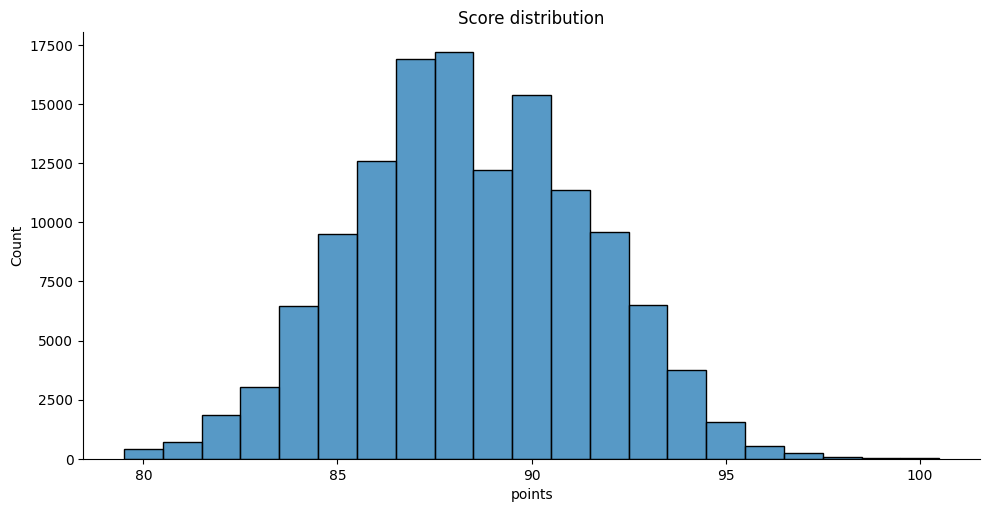

In [ ]:
# Отобразить гистограмму для переменной points
sns.displot(df, x=df['points'], discrete=True, aspect=2)
plt.title('Score distribution')
plt.show()

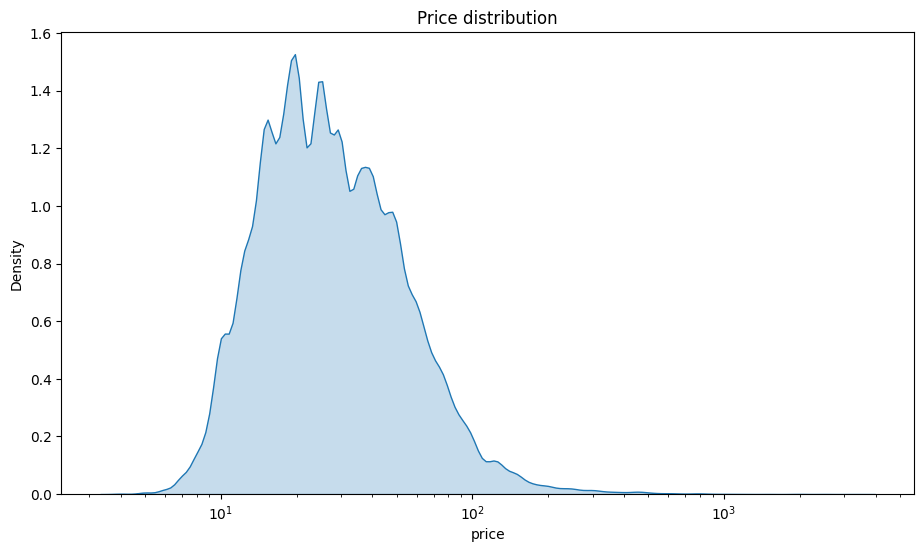

In [ ]:
# Отобразить плотность распределения для переменной price
plt.figure(figsize=(11,6))
sns.kdeplot(df['price'], log_scale=True, fill=True)
plt.title('Price distribution')
plt.show()

Гистограмма обычно используется для визуализации дискретных значений переменной, когда нам нужно увидеть частоту встречаемости каждого значения. 

Визуализация плотности распределения лучше подходит для непрерывных переменных, особенно если нам интересно увидеть форму распределения или найти наиболее вероятное значение (моду).

# **3. Поиск зависимостей**

In [ ]:
# Рассчитать корреляцию и p-value между переменными points и price
new = df[['points', 'price']].copy()
new.dropna(inplace=True) # удаление строк с NaN
corr, p_value = spearmanr(new['points'], new['price'])
print(f'correlation: {corr:.3f}')
print(f'p-value: {p_value:.3f}')

correlation: 0.606
p-value: 0.000


In [ ]:
# Oтразить доверительный интервал для коэффициента корреляции
n = len(new['points'])
deg_f = n - 2  
t_stat = t.ppf(0.89, df=deg_f) 
se = 1 / ((n-2)**0.5)
lower, upper = corr - t_stat*se, corr + t_stat*se
print(f'Доверительный интервал: lower - {lower:.3f}, upper - {upper:.3f}')

Доверительный интервал: lower - 0.602, upper - 0.609


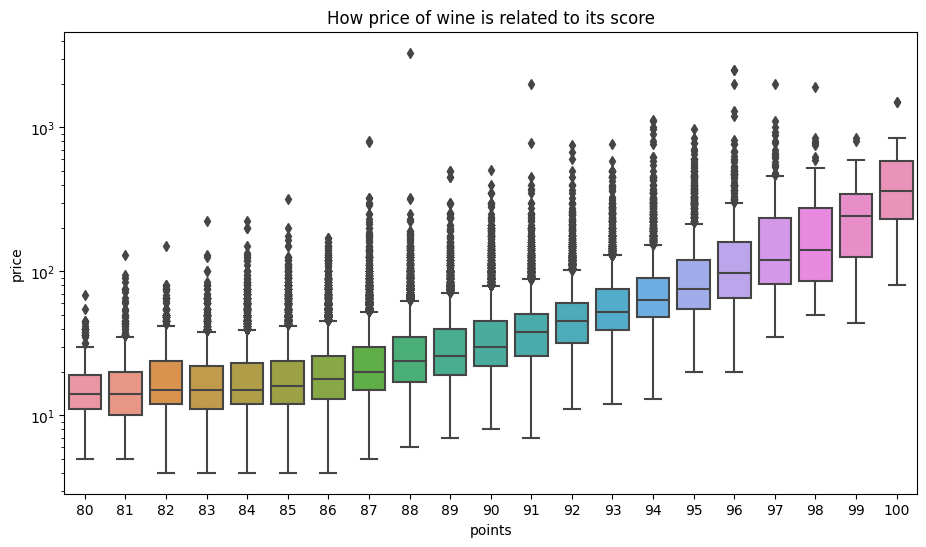

In [ ]:
# Визуализировать связь между переменными points и price
plt.figure(figsize=(11,6))
ax = sns.boxplot(df, x='points', y='price')
ax.set(yscale="log")
plt.title('How price of wine is related to its score')
plt.show()

Box plot (ящик с усами) является одним из наиболее популярных методов визуализации связи между двумя переменными. Его популярность обусловлена тем, что он позволяет быстро оценить распределение данных, идентифицировать выбросы (выбивающиеся наблюдения) и выявить различия между группами. Кроме того, box plot компактен, что позволяет отобразить множество групп на одной оси и сравнить их между собой. 

Другие способы визуализации, такие как: scatter plots (диаграммы рассеяния), line plots (линейные графики), и heat maps (тепловые карты), могут быть менее эффективными при большом количестве наблюдений или переменных. Поэтому box plot является более универсальным методом визуализации связи между двумя переменными.

# **4. Анализ текстовой информации**

In [ ]:
# Найти 6 наиболее активных дегустаторов (с наибольшим количеством оставленных отзывов)
top_tasters = df['taster_name'].value_counts()[:6]
print('Наиболее активные дегустаторы:\n')
top_tasters

Наиболее активные дегустаторы:



Roger Voss           25512
Michael Schachner    15127
Kerin O’Keefe        10776
Virginie Boone        9537
Paul Gregutt          9531
Matt Kettmann         6332
Name: taster_name, dtype: int64

In [ ]:
df = df.loc[df['taster_name'].isin(top_tasters.index), ['taster_name', 'description']]
df['description'] = df['description'].str.lower()
df.head()

,taster_name,description
286,Michael Schachner,this brazilian merlot smells rubbery and gaseo...
287,Michael Schachner,oily aromas of orange peel and tropical fruits...
289,Michael Schachner,"this is mentholated and spicy, with a brandied..."
290,Michael Schachner,oily aromas of orange peel and tropical fruits...
292,Michael Schachner,this brazilian merlot smells rubbery and gaseo...


In [ ]:
# Разбить текст на токены (слова)
regexp = RegexpTokenizer('\w+')
df['text_token']=df['description'].apply(regexp.tokenize)
df.head(3)

,taster_name,description,text_token
286,Michael Schachner,this brazilian merlot smells rubbery and gaseo...,"[this, brazilian, merlot, smells, rubbery, and..."
287,Michael Schachner,oily aromas of orange peel and tropical fruits...,"[oily, aromas, of, orange, peel, and, tropical..."
289,Michael Schachner,"this is mentholated and spicy, with a brandied...","[this, is, mentholated, and, spicy, with, a, b..."


In [ ]:
# Удалить «стоп-слова» 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['a', 'the', 'this', 'it'])

df['clean'] = df['text_token'].apply(lambda x: [item for item in x if item not in stop_words])
df.head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,taster_name,description,text_token,clean
286,Michael Schachner,this brazilian merlot smells rubbery and gaseo...,"[this, brazilian, merlot, smells, rubbery, and...","[brazilian, merlot, smells, rubbery, gaseous, ..."
287,Michael Schachner,oily aromas of orange peel and tropical fruits...,"[oily, aromas, of, orange, peel, and, tropical...","[oily, aromas, orange, peel, tropical, fruits,..."
289,Michael Schachner,"this is mentholated and spicy, with a brandied...","[this, is, mentholated, and, spicy, with, a, b...","[mentholated, spicy, brandied, cherry, note, d..."


In [ ]:
# Найти количество использований слов каждым дегустатором 

#Создаем новый датафрейм, в котором будут храниться десять наиболее часто встречаемых слов для каждого дегустатора:
df_top_words = pd.DataFrame(columns=['taster_name', 'word', 'count'])

#Заполним датафрейм, используя цикл по всем дегустаторам:
for taster in df['taster_name'].unique():
    # список всех слов, использованных дегустатором
    words = [word for sublist in df[df['taster_name'] == taster]['clean'].tolist() for word in sublist]
    # словарь с количеством повторений каждого слова
    words_count = Counter(words)
    # выбираем 10 наиболее часто встречающихся слов
    top_words = words_count.most_common(10)
    # создаем временный датафрейм с топ-словами
    df_temp = pd.DataFrame(top_words, columns=['word', 'count'])
    # добавляем в датафрейм информацию о дегустаторе
    df_temp['taster_name'] = taster
    # добавляем временный датафрейм к общему датафрейму
    df_top_words = pd.concat([df_top_words, df_temp])
# Сортируем по убыванию
df_top_words = df_top_words.sort_values('count', ascending=False)
df_top_words.head(10)

,taster_name,word,count
0,Roger Voss,wine,33069
0,Michael Schachner,flavors,13783
1,Roger Voss,acidity,13756
2,Roger Voss,drink,13342
1,Michael Schachner,aromas,11472
2,Michael Schachner,finish,10708
3,Roger Voss,ripe,10250
4,Roger Voss,fruit,10220
0,Kerin O’Keefe,palate,9991
5,Roger Voss,fruits,9169


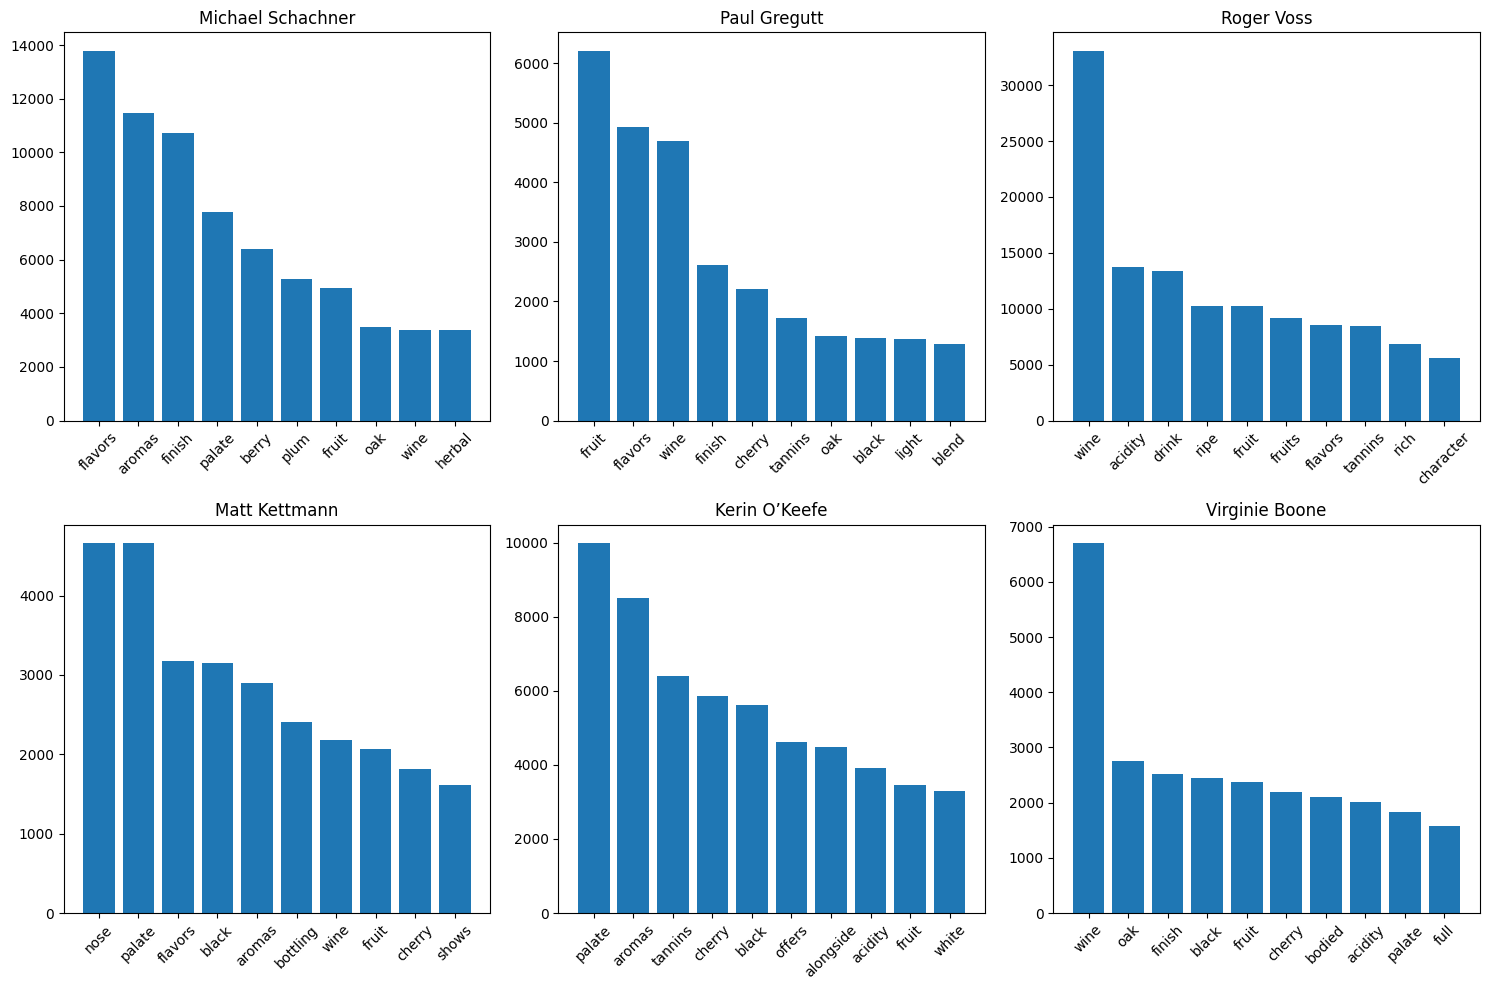

In [ ]:
# Отразить 10 наиболее часто используемых слов для каждого дегустатора
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

for i, taster in enumerate(df['taster_name'].unique()):
    df_plot = df_top_words[df_top_words['taster_name'] == taster]
    ax[i].bar(df_plot['word'], df_plot['count'])
    ax[i].set_title(taster)
    ax[i].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()